In [1]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import math
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp
import copy
import warnings
from nolitsa import data

c:\ANACONDA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
y_pred = []
                
prediction_steps = 10
exchange = 40000
                
units = 100
leak_rate = 0.3
spectral_radius = 0.8
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
                
seed = 1234

In [3]:
#X = np.concatenate((X0, X1, X2, X3), axis=1)

In [4]:
def results(y_test, y_pred, sample=1500, prediction_steps=10):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")
    #ax.axvline(x=sample-len(self.X_test), color="blue")  # Add vertical line
    ax.axvline(x=sample-prediction_steps, color="red")  # Add vertical line
    ax.legend()
    plt.show()

In [15]:
def get_traj(n, x0 = [0.62225717, -0.08232857, 30.60845379]):
    
    dt = 0.01
    X = []
    tm = []
    x00 = x0

    for i in range(n):

        for j in range(len(x0)):
            x00[j] = x0[j] + (-1)**j + 2/(i+1)

        xt = data.lorenz(length=100000, sample=dt, x0=x00,
                sigma=16.0, beta=4.0, rho=45.92)[1]

        time = copy.deepcopy(xt) #берем значения Лоренца
        X0 = time[:,0] #берем только x
        X0 = X0.reshape(100000,1) #зачем-то 
        X0 = 2 * (X0 - X0.min()) / (X0.max() - X0.min()) - 1 #нормализация

        tm.append(X0)
        
    X = np.concatenate(tm, axis=1)

    return X

In [16]:
X = get_traj(4)

In [17]:
exchange = 50000
x, y = to_forecasting(X, forecast=prediction_steps)
X_train, y_train = x[:exchange], y[:exchange]
X_test, y_test = x[exchange:], y[exchange:]

In [18]:
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                            lr=leak_rate, rc_connectivity=connectivity,
                            input_connectivity=input_connectivity, seed=seed)

readout = Ridge(4, ridge=regularization) # 1 - кол-во выходных нейронов
esn = reservoir >> readout
esn = esn.fit(X_train, y_train, warmup=10) # Прикол)))

y_pred = esn.run(X_test)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-0: 50000it [00:10, 4895.76it/s]
Running Model-0: 100%|██████████| 1/1 [00:10<00:00, 10.26s/it]


Fitting node Ridge-0...


Running Model-0: 49990it [00:06, 7443.67it/s]         


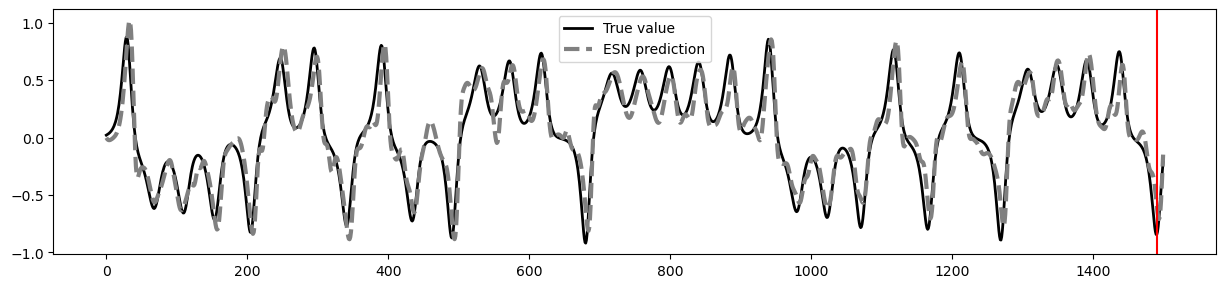

In [19]:
results(y_test.T[1], y_pred.T[1], sample=1500, prediction_steps=10)

In [20]:
def Norma (W):
    sigm = 0
    for i in range(len(W)):
        sigm = sigm + (math.fabs(W[i]))*2
    return math.sqrt(sigm)

In [21]:
Wout = readout.give_Wout()

In [23]:
Wout

array([[ 3.08859759e-01,  1.08271367e-01,  5.88076459e-01,
        -4.44508421e-01],
       [ 1.18888866e-01,  4.25631895e-01, -5.30157688e-02,
         1.68804402e-01],
       [ 8.23452714e-01,  3.29748717e-01, -1.00977448e+00,
        -1.03348270e+00],
       [-5.75215758e+00, -6.55400997e+00, -2.98710987e+00,
        -2.03305599e+00],
       [ 8.87555531e-01,  1.83705554e+00,  9.87795445e-01,
         5.65424448e-02],
       [-1.17553601e+00, -1.14645242e+01,  2.17888907e+00,
        -5.45822528e-01],
       [ 5.94308056e-01,  4.74810193e+00,  4.38981254e+00,
        -4.45282206e+00],
       [ 1.03769025e+00, -4.58628175e+00, -3.30813208e-02,
         2.85788036e-02],
       [ 1.93908087e+00,  4.12750085e-01, -2.62376468e+00,
        -5.01699034e-01],
       [ 8.75009562e-01, -1.63183794e-01, -5.45519478e-01,
         2.05505813e-01],
       [ 2.67881714e+00,  1.63394022e+00, -5.21476911e-01,
        -1.00655018e+00],
       [-4.66548118e+00, -6.91192799e+00, -1.26135092e+00,
      

In [26]:
Wout.T[0]

array([  0.30885976,   0.11888887,   0.82345271,  -5.75215758,
         0.88755553,  -1.17553601,   0.59430806,   1.03769025,
         1.93908087,   0.87500956,   2.67881714,  -4.66548118,
        -1.53395502,  -0.09216103,  -1.65876192,   0.40102998,
         1.23386981,   2.97317007,  -1.5663898 ,  -1.03613547,
        -3.52955953,  -1.45410218,  -2.7414651 ,   0.18428363,
        -1.24307175,  -2.22938455,   0.77558295,  -1.87563864,
         0.89523721,  -1.85372321,  24.29126467,   2.10094052,
        -0.02747861,   4.13887568,  -4.61383189,   3.29218853,
         0.89792434,   0.76099691,   1.39049227,   4.04620147,
         1.43770697,   4.69611675,  -2.47595167,   6.3981336 ,
        -0.72064964,   0.07135907,   1.32154866,  -1.41206161,
         0.8529668 ,  -1.29719986,  -0.27561252,   1.55152475,
         2.37969522,   5.16883576,  -1.71297845,  -2.37616202,
         0.15569874,  -3.90280008,  -4.11522067,   4.56841545,
        -0.93466558,   1.17746842,   1.0749131 ,   0.33

In [25]:
normWout4 = Norma(Wout.T[0])
normWout4

20.98309500793928

In [27]:
len(Wout.T[0])

100

Running Model-6: 50000it [00:07, 6713.10it/s]?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


Fitting node Ridge-6...


Running Model-6: 49990it [00:07, 6875.26it/s]         


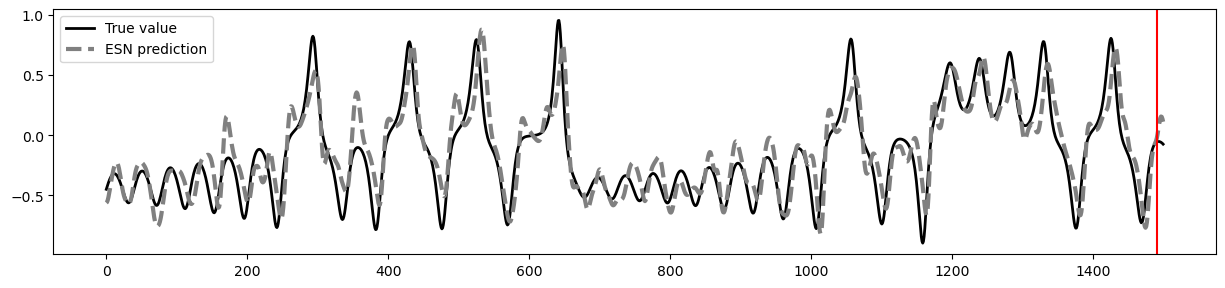

array([[-7.57647195e-01, -1.60413753e+00, -6.68102297e-02,
        -8.71870235e-02,  4.85576793e-01],
       [ 6.02999389e-01,  1.05906828e+00,  7.82282274e-01,
        -9.64374669e-01, -8.02040138e-01],
       [ 2.92737747e-01, -9.71937564e-01,  8.55195142e-01,
        -1.40261423e+00,  9.49115332e-01],
       [-1.09174149e+00, -1.85010975e+00, -9.07424811e-01,
         1.32362486e+00,  6.95442544e-01],
       [-1.80702237e-01, -5.67776779e-01, -3.09936762e-01,
        -4.52181635e-01, -5.29956340e-01],
       [-2.29617942e+00,  4.33177600e+00, -4.89388023e+00,
        -4.46917298e+00, -6.01332637e-01],
       [-1.93400114e-01, -9.57387447e-01,  1.93048928e+00,
         1.57925935e-01,  6.80649807e-01],
       [-9.70251478e-01, -4.67931596e-01,  8.62130670e-01,
         1.02960105e-01, -5.74728625e-01],
       [-6.40092611e-01, -8.15063360e-01, -7.53864318e-01,
        -6.91196919e-01,  1.24330730e+00],
       [-1.00052807e+00, -3.00894104e+00, -2.18960108e+00,
         2.46295150e-01

In [33]:
X = get_traj(5)

exchange = 50000
x, y = to_forecasting(X, forecast=prediction_steps)
X_train, y_train = x[:exchange], y[:exchange]
X_test, y_test = x[exchange:], y[exchange:]

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                            lr=leak_rate, rc_connectivity=connectivity,
                            input_connectivity=input_connectivity, seed=seed)

readout = Ridge(5, ridge=regularization) # 1 - кол-во выходных нейронов
esn = reservoir >> readout
esn = esn.fit(X_train, y_train, warmup=15) # Прикол)))

y_pred = esn.run(X_test)

results(y_test.T[1], y_pred.T[1], sample=1500, prediction_steps=10)
Wout = readout.give_Wout()

Wout